In [17]:
from __future__ import print_function

import os

import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pickle

In [18]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [19]:
train_set = torchvision.datasets.CIFAR100('../dataset', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR100('../dataset', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, 
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
classes = ('cattle',
'dinosaur',
'apple',
'boy',
'aquarium_fish',
'telephone',
'train',
'cup',
'cloud',
'elephant',
'keyboard',
'willow_tree',
'sunflower',
'castle',
'sea',
'bicycle',
'wolf',
'squirrel',
'shrew',
'pine_tree',
'rose',
'television',
'table',
'possum',
'oak_tree',
'leopard',
'maple_tree',
'rabbit',
'chimpanzee',
'clock',
'streetcar',
'cockroach',
'snake',
'lobster',
'mountain',
'palm_tree',
'skyscraper',
'tractor',
'shark',
'butterfly',
'bottle',
'bee',
'chair',
'woman',
'hamster',
'otter',
'seal',
'lion',
'mushroom',
'girl',
'sweet_pepper',
'forest',
'crocodile',
'orange',
'tulip',
'mouse',
'camel',
'caterpillar',
'man',
'skunk',
'kangaroo',
'raccoon',
'snail',
'rocket',
'whale',
'worm',
'turtle',
'beaver',
'plate',
'wardrobe',
'road',
'fox',
'flatfish',
'tiger',
'ray',
'dolphin',
'poppy',
'porcupine',
'lamp',
'crab',
'motorcycle',
'spider',
'tank',
'orchid',
'lizard',
'beetle',
'bridge',
'baby',
'lawn_mower',
'house',
'bus',
'couch',
'bowl',
'pear',
'bed',
'plain',
'trout',
'bear',
'pickup_truck',
'can')

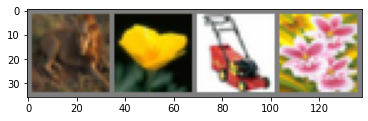

In [21]:
import matplotlib.pyplot as plt


def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [23]:
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

class CoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // reduction)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()
        
        self.conv_h = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        

    def forward(self, x):
        identity = x
        
        n,c,h,w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y) 
        
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identity * a_w * a_h

        return out

In [24]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1,downsample = None):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
        self.ca = CoordAtt(self.expansion * out_channels,self.expansion * out_channels)
        self.downsample = downsample
            
    def forward(self, x):
        identity = x
        
        out = self.features(x)
        out += self.shortcut(x)
        #print(out.shape)
        #print(x.shape)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out = self.ca(out) + identity
        
        out = torch.relu(out)
        return out

In [25]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1,
                 norm_layer=None):
        super(BottleneckBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, 1, bias=False)
        self.bn1 = norm_layer(width)
        self.conv2 = nn.Conv2d(width, width, 3, padding=dilation, stride=stride, groups=groups, dilation=dilation,
                               bias=False)
        self.bn2 = norm_layer(width)
        self.conv3 = nn.Conv2d(width, planes * self.expansion, 1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.stride = stride
        self.ca = CoordAtt(planes * self.expansion, planes * self.expansion)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.ca(out)  # add CA
        out += identity
        out = self.relu(out)

        return out

In [26]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        downsample=None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion), )

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        layers.append(block(self.in_channels, out_channels, stride,downsample))
        self.in_channels = out_channels * block.expansion
        
        '''
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        '''
            
        for i in range(1,len(strides)):
            layers.append(block(self.in_channels, out_channels, strides[i]))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [27]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

net = ResNet18().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)

    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (ca): CoordAtt(
        (pool_h): AdaptiveAvgPool2d(output_size=(None, 1))
        (pool_w): AdaptiveAvgPool2d(output_size=(1, None))
        (conv1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(8, eps=1e-05

In [28]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [29]:
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [30]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [31]:
def plot_loss(train_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
train_losses = []


for epoch in range(start_epoch, 50):
    loss = train(epoch)
    train_losses.append(loss)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss, epoch=epoch)


Epoch: 0
[1,   100] loss: 489.780946 |  Acc: 1.688% (27/1600)
[1,   200] loss: 943.982102 |  Acc: 1.812% (58/3200)
[1,   300] loss: 1389.460536 |  Acc: 2.188% (105/4800)
[1,   400] loss: 1826.621128 |  Acc: 2.594% (166/6400)
[1,   500] loss: 2256.077690 |  Acc: 2.888% (231/8000)
[1,   600] loss: 2674.167921 |  Acc: 3.125% (300/9600)
[1,   700] loss: 3091.437051 |  Acc: 3.411% (382/11200)
[1,   800] loss: 3506.791125 |  Acc: 3.695% (473/12800)
[1,   900] loss: 3917.531459 |  Acc: 3.972% (572/14400)
[1,  1000] loss: 4324.377301 |  Acc: 4.219% (675/16000)
[1,  1100] loss: 4732.249212 |  Acc: 4.364% (768/17600)
[1,  1200] loss: 5129.901251 |  Acc: 4.677% (898/19200)
[1,  1300] loss: 5528.040231 |  Acc: 4.918% (1023/20800)
[1,  1400] loss: 5927.982616 |  Acc: 5.138% (1151/22400)
[1,  1500] loss: 6320.080303 |  Acc: 5.450% (1308/24000)
[1,  1600] loss: 6718.648136 |  Acc: 5.648% (1446/25600)
[1,  1700] loss: 7108.038724 |  Acc: 5.886% (1601/27200)
[1,  1800] loss: 7500.520057 |  Acc: 6.049%

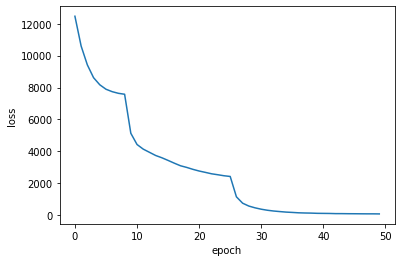

In [32]:
plot_loss(train_losses)

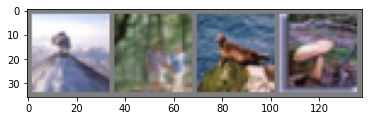

GroundTruth:   girl lobster flatfish forest
Predicted:  plate lawn_mower flatfish forest
Accuracy of the network on the 10000 test images: 64 %


In [33]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100.00 * correct / total))

In [34]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [35]:
for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100.00 * class_correct[i] / class_total[i]))

Accuracy of cattle : 83 %
Accuracy of dinosaur : 81 %
Accuracy of apple : 56 %
Accuracy of   boy : 72 %
Accuracy of aquarium_fish : 48 %
Accuracy of telephone : 62 %
Accuracy of train : 80 %
Accuracy of   cup : 58 %
Accuracy of cloud : 83 %
Accuracy of elephant : 78 %
Accuracy of keyboard : 41 %
Accuracy of willow_tree : 42 %
Accuracy of sunflower : 71 %
Accuracy of castle : 69 %
Accuracy of   sea : 59 %
Accuracy of bicycle : 52 %
Accuracy of  wolf : 60 %
Accuracy of squirrel : 90 %
Accuracy of shrew : 64 %
Accuracy of pine_tree : 88 %
Accuracy of  rose : 87 %
Accuracy of television : 83 %
Accuracy of table : 68 %
Accuracy of possum : 84 %
Accuracy of oak_tree : 88 %
Accuracy of leopard : 68 %
Accuracy of maple_tree : 68 %
Accuracy of rabbit : 31 %
Accuracy of chimpanzee : 71 %
Accuracy of clock : 78 %
Accuracy of streetcar : 58 %
Accuracy of cockroach : 35 %
Accuracy of snake : 52 %
Accuracy of lobster : 71 %
Accuracy of mountain : 75 %
Accuracy of palm_tree : 44 %
Accuracy of skyscra